#### Import Relevant Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from split_data_utils import train_test_spliting
from data_preprocessing import lemmatize_text_with_pos, tokens
from ngram_utils import generate_ngrams, build_ngram_vocab, bag_of_ngrams
from tf_idf_embedding_utils import tf_idf, tokenise, build_vocabulary, log_count_terms, count_terms

from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')  # Download the punkt tokenizer data
nltk.download('wordnet')  # Download the WordNet data
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maryk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maryk\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\maryk\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

#### Dataset 

In [13]:
df = pd.read_excel("Humour_style.xlsx")   # Read Excel dataset 
df = df[['JOKES', 'LABELS']]              # Extract Only the Jokes and Labels Column
df = df[:1263]  

train_ratio = 0.8
seed = 100
x_train, x_test, y_train, y_test = train_test_spliting(df,train_ratio,seed)

y_train = y_train.astype("int32")
y_test  = y_test.astype("int32")
print("x_train",x_train.shape)   # Get the shape of the training features (Number of instance, number of features/column)
print("y_train",y_train.dtype)   # Get the shape of the training label (Number of instance, number of column)
print("x_test",x_test.dtype)
print("y_test",y_test.shape)

print(x_train)

x_train (1010,)
y_train int32
x_test object
y_test (253,)
['4 ways to become a better risk taker'
 '“Never argue with stupid people, they will drag you down to their level and then beat you with experience.”'
 '“Worrying is like paying a debt you don’t owe.”' ...
 "Worker dies at minnesota vikings' stadium construction site"
 "sharps' injuries could pose hiv, hepatitis risk to surgeons"
 "My set is full of them, but I have a go to bit about how awful it is being a fat chick with small tits that almost always saves me when I'm faltering."]


#### Data preprocessing

In [14]:
# Lemmatize each example in the train dataset
lemmatized_x_train  = [lemmatize_text_with_pos(example) for example in x_train]

# Lemmatize each example in the test dataset
lemmatized_x_test  = [lemmatize_text_with_pos(example) for example in x_test]

x_train = np.array(lemmatized_x_train )   # Convert Train data to Numpy Array 
x_test = np.array(lemmatized_x_test)      # Convert Test data to Numpy Array

#### Bag-of-Ngram

In [15]:
### Get vocabulary size from train dataset
train_vocab  = set()

# Build the vocabulary from train N-grams
for example in x_train:
    vocabs = generate_ngrams(example,2)
    train_vocab.update(vocabs)

print(f"Vocabulary Size: {len(train_vocab)}")

# Convert train N-grams to vectors using the vocabulary
def convert_to_vectors(data, vocab):
    features = []
    for example in data:
        vectors = bag_of_ngrams(example, 2, vocab)
        features.append(vectors)
    return np.squeeze(np.array(features))

# Convert train N-grams to vectors
xtrain_features = convert_to_vectors(x_train, train_vocab)

# Convert test N-grams to vectors using the same vocabulary
xtest_features = convert_to_vectors(x_test, train_vocab)

print(f"Train Features Shape: {xtrain_features.shape}")
print(f"Test Features Shape: {xtest_features.shape}")

Vocabulary Size: 11794
Train Features Shape: (1010, 11794)
Test Features Shape: (253, 11794)


#### Feedforward Neural Network

#### Dataset preprocessing to Tensor


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Creates a Tensor from a numpy.ndarray.
# Any changes you make to the tensor will reflect in the original NumPy array
x_train_tensor = torch.from_numpy(xtrain_features).float()
y_train_tensor = torch.from_numpy(y_train).float()
x_test_tensor = torch.from_numpy(xtest_features).float()
y_test_tensor = torch.from_numpy(y_test).float()

## Changing labels to one-hot encoding to match output size
y_train_tensor = y_train_tensor.long() # If y_train_tensor is of type float, convert it to integer first
num_classes = len(torch.unique(y_train_tensor)) # Determine the number of classes
y_train_tensor = F.one_hot(y_train_tensor, num_classes=num_classes) # Convert to one-hot encoding
y_train_tensor = y_train_tensor.float() #Convert long type back to float as BCELOSS uses float

# Ask PyTorch to store any computed gradients so that we can examine them
x_train_tensor.requires_grad_(True)

# should be "None" at the moment. It will only be filled later after you call backward()
print(x_train_tensor.grad)

# Use a GPU if it exists
if torch.cuda.is_available():
    x_train_tensor = x_train_tensor.to('cuda')
    x_test_tensor = x_test_tensor.to('cuda')
    y_train_tensor = y_train_tensor.to('cuda')

print(y_train_tensor.shape)
print(num_classes)

None
torch.Size([1010, 5])
5


#### FNN Model

In [17]:
class NeuralNetworksPytorch(nn.Module):
    def __init__(self, n_input, h1=200, h2 =250, h3=210, n_output=5):
        super().__init__() #Instantiate our nn.Module
        self.fully_connected1 = nn.Linear(n_input, h1)
        self.fully_connected2 = nn.Linear(h1, h2)
        self.fully_connected3 = nn.Linear(h2, h3)
        self.out = nn.Linear(h3, n_output)

    def forward(self, x):
        # Performs Forward Pass
        x = F.relu(self.fully_connected1(x))
        x = F.tanh(self.fully_connected2(x))
        x = F.relu(self.fully_connected3(x))
        x = torch.softmax(self.out(x), dim=1)

        return x

In [99]:
#Pick a Manual seed for randomisation
torch.manual_seed(10)

input_n = xtrain_features.shape[1]
py_model = NeuralNetworksPytorch(input_n)

if torch.cuda.is_available():
    py_model.to('cuda')

print(py_model.out.weight) # Print Weights
print(py_model.out.bias)   # Print Bias
print(list(py_model.parameters())) # Print LR parameters (Both weight and Bias)

Parameter containing:
tensor([[ 0.0663, -0.0198,  0.0347,  ..., -0.0162, -0.0335,  0.0443],
        [-0.0687, -0.0646,  0.0107,  ...,  0.0671, -0.0221,  0.0557],
        [ 0.0140,  0.0259,  0.0147,  ...,  0.0222,  0.0171,  0.0258],
        [-0.0306,  0.0520,  0.0449,  ...,  0.0559, -0.0357,  0.0179],
        [-0.0508, -0.0315, -0.0385,  ..., -0.0182,  0.0290,  0.0373]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.0603,  0.0358,  0.0118,  0.0541, -0.0087], device='cuda:0',
       requires_grad=True)
[Parameter containing:
tensor([[-0.0015, -0.0006, -0.0068,  ...,  0.0010,  0.0180, -0.0109],
        [-0.0087,  0.0131, -0.0139,  ..., -0.0162, -0.0045,  0.0034],
        [-0.0133, -0.0166,  0.0082,  ..., -0.0174,  0.0134,  0.0085],
        ...,
        [ 0.0088,  0.0053, -0.0110,  ...,  0.0012, -0.0055, -0.0028],
        [ 0.0013,  0.0065, -0.0037,  ...,  0.0161, -0.0048, -0.0143],
        [-0.0048, -0.0018, -0.0053,  ...,  0.0055, -0.0117,  0.0155]],
      

In [100]:
criterion = nn.CrossEntropyLoss() # Binary cross entropy 

optimiser = torch.optim.Adam(py_model.parameters(), lr=0.0001)

n_epoch = 1000
losses = []


for epoch in range(n_epoch):
    # Reset the gradients
    optimiser.zero_grad()

    # forward pass
    y_hat = py_model(x_train_tensor)
    #print(y_hat.shape)

    # compute loss
    loss = criterion(y_hat, y_train_tensor)
    loss_np = loss.detach().cpu().numpy()    #Keep Track of losses
    losses.append(loss_np)

    # Backward pass (compute the gradients)
    loss.backward()

    # update parameters (weight and bias)
    optimiser.step()

    # print(f"Epoch: {epoch}\t w: {model.linear.weight.data[0]}\t b: {model.linear.bias.data[0]:.4f} \t L: {loss:.4f}")
    print(f"Epoch: {epoch}\t L: {loss:.4f}")

Epoch: 0	 L: 1.6091
Epoch: 1	 L: 1.6089
Epoch: 2	 L: 1.6086
Epoch: 3	 L: 1.6084
Epoch: 4	 L: 1.6082
Epoch: 5	 L: 1.6080
Epoch: 6	 L: 1.6078
Epoch: 7	 L: 1.6076
Epoch: 8	 L: 1.6073
Epoch: 9	 L: 1.6071
Epoch: 10	 L: 1.6069
Epoch: 11	 L: 1.6066
Epoch: 12	 L: 1.6063
Epoch: 13	 L: 1.6061
Epoch: 14	 L: 1.6058
Epoch: 15	 L: 1.6055
Epoch: 16	 L: 1.6052
Epoch: 17	 L: 1.6049
Epoch: 18	 L: 1.6045
Epoch: 19	 L: 1.6042
Epoch: 20	 L: 1.6038
Epoch: 21	 L: 1.6034
Epoch: 22	 L: 1.6030
Epoch: 23	 L: 1.6025
Epoch: 24	 L: 1.6020
Epoch: 25	 L: 1.6015
Epoch: 26	 L: 1.6010
Epoch: 27	 L: 1.6005
Epoch: 28	 L: 1.5999
Epoch: 29	 L: 1.5992
Epoch: 30	 L: 1.5986
Epoch: 31	 L: 1.5979
Epoch: 32	 L: 1.5972
Epoch: 33	 L: 1.5964
Epoch: 34	 L: 1.5956
Epoch: 35	 L: 1.5947
Epoch: 36	 L: 1.5938
Epoch: 37	 L: 1.5928
Epoch: 38	 L: 1.5917
Epoch: 39	 L: 1.5906
Epoch: 40	 L: 1.5895
Epoch: 41	 L: 1.5883
Epoch: 42	 L: 1.5870
Epoch: 43	 L: 1.5856
Epoch: 44	 L: 1.5841
Epoch: 45	 L: 1.5826
Epoch: 46	 L: 1.5809
Epoch: 47	 L: 1.5792
Ep

Text(0.5, 0, 'Epoch')

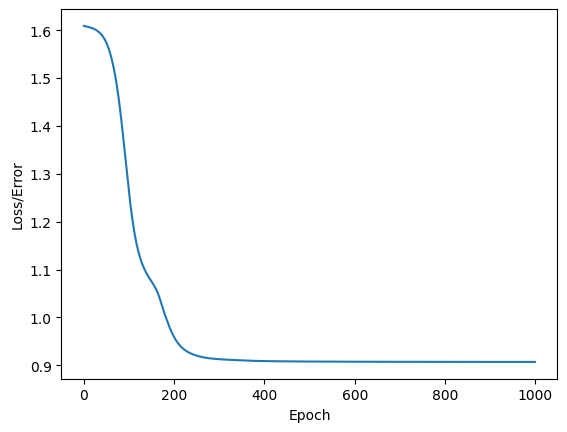

In [101]:
## Graph it out

plt.plot(range(n_epoch), losses)
plt.ylabel("Loss/Error")
plt.xlabel("Epoch")

##### Prediction

In [102]:
y_predictions = py_model.forward(x_test_tensor) # prediction is in one-hot encoded form
binary_y_predictions= torch.argmax(y_predictions, dim=1) #convert it back to a one-dimensional tensor with binary values (0 or 1).
binary_y_predictions = binary_y_predictions.to(torch.int64)


y_predictions
binary_y_predictions
#y_test_tensor

tensor([3, 0, 3, 0, 2, 0, 4, 3, 3, 3, 2, 3, 0, 4, 0, 0, 3, 3, 3, 0, 1, 1, 3, 0,
        2, 3, 4, 2, 1, 4, 0, 3, 0, 0, 2, 0, 0, 1, 3, 3, 2, 0, 1, 4, 2, 0, 2, 3,
        3, 1, 4, 2, 3, 3, 3, 4, 0, 0, 0, 4, 3, 0, 3, 0, 3, 3, 0, 4, 0, 4, 0, 1,
        0, 2, 2, 1, 1, 1, 3, 0, 0, 1, 1, 0, 1, 4, 0, 1, 4, 1, 1, 4, 3, 3, 0, 0,
        3, 1, 1, 0, 0, 3, 1, 0, 4, 1, 4, 4, 4, 0, 0, 3, 1, 4, 0, 2, 0, 0, 3, 0,
        4, 3, 1, 3, 0, 2, 4, 0, 4, 3, 1, 0, 2, 1, 2, 4, 1, 2, 3, 0, 4, 2, 4, 4,
        4, 3, 4, 1, 4, 0, 3, 0, 1, 0, 2, 0, 4, 1, 1, 2, 0, 4, 4, 4, 3, 4, 2, 4,
        4, 4, 3, 1, 3, 2, 2, 3, 3, 3, 3, 1, 2, 0, 1, 0, 0, 0, 1, 3, 0, 2, 2, 2,
        0, 1, 2, 3, 3, 0, 1, 4, 0, 0, 1, 0, 1, 3, 0, 2, 1, 3, 4, 2, 0, 1, 4, 3,
        3, 1, 1, 4, 2, 1, 3, 2, 2, 3, 2, 2, 1, 3, 2, 0, 4, 3, 4, 2, 4, 4, 1, 1,
        1, 2, 1, 0, 0, 0, 4, 4, 3, 4, 4, 0, 4], device='cuda:0')

In [103]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Assuming y_predictions contains the predicted class indices
# and y_test_tensor contains the true class indices

# Sample data (replace these with your actual predictions and true labels)

# Convert PyTorch tensors to numpy arrays
multi_y_predictions = y_predictions.detach().cpu().numpy()
multi_y_true = y_test_tensor.detach().cpu().numpy()

# Convert predicted probabilities to class indices
predicted_labels = np.argmax(multi_y_predictions, axis=1)

# Compute metrics
accuracy = accuracy_score(multi_y_true, predicted_labels)
precision = precision_score(multi_y_true, predicted_labels, average='weighted')
recall = recall_score(multi_y_true, predicted_labels, average='weighted')
f1 = f1_score(multi_y_true, predicted_labels, average='weighted')

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(multi_y_true, predicted_labels))

Accuracy: 0.6759
Precision: 0.6779
Recall: 0.6759
F1 Score: 0.6727

Classification Report:
              precision    recall  f1-score   support

         0.0       0.63      0.79      0.70        52
         1.0       0.64      0.60      0.62        50
         2.0       0.65      0.49      0.56        49
         3.0       0.62      0.65      0.64        52
         4.0       0.86      0.84      0.85        50

    accuracy                           0.68       253
   macro avg       0.68      0.67      0.67       253
weighted avg       0.68      0.68      0.67       253

